In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 00:07:52.816057: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 00:07:54.458105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 2870
end_idx = 3120
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(250, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(250, 96, 7)
(168000,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(250, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(250, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 00:08:04.062593: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:89:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 16

sol_per_pop = 96
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 00:08:07.313964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 3ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step


8/8 [==============================] - 0s 4ms/step
CPU time: 6793.0163278148975 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

8/8 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.95247562 0.98957028 0.79186329 ... 0.17234465 0.31280515 0.71829379]
Fitness value of the best solution = 0.0015123942830004627


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

8/8 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


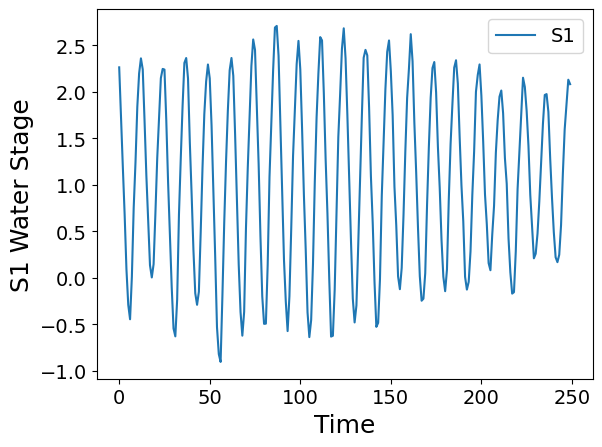

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low5.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.952476,0.989570,0.791863,0.573921,0.817490,0.733030,0.294476,0.939732,0.687577,0.754204,...,0.396543,0.877528,0.614599,0.043819,0.395984,0.841253,0.245002,0.834158,0.797543,0.832204
1,0.936142,0.021907,0.413407,0.200377,0.652423,0.308039,0.615443,0.540142,0.823033,0.990714,...,0.335647,0.574416,0.360825,0.606526,0.054476,0.081650,0.458209,0.601334,0.117367,0.416203
2,0.736300,0.812260,0.981693,0.464828,0.632985,0.404441,0.444877,0.664926,0.514706,0.183572,...,0.784891,0.534383,0.639086,0.135601,0.717746,0.481824,0.864561,0.001473,0.193521,0.401328
3,0.411594,0.648118,0.675930,0.538346,0.673346,0.487281,0.822878,0.881104,0.517407,0.463238,...,0.046808,0.793365,0.515193,0.690606,0.764755,0.533618,0.569837,0.498624,0.187077,0.359316
4,0.422979,0.508446,0.917324,0.034368,0.065268,0.781114,0.034916,0.321688,0.807004,0.989528,...,0.687480,0.196851,0.537329,0.818459,0.746696,0.656106,0.549725,0.465446,0.846250,0.850221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.619247,0.990010,0.313885,0.894718,0.036517,0.828384,0.550439,0.984538,0.861421,0.091069,...,0.663069,0.411215,0.038245,0.122207,0.762574,0.038608,0.417425,0.400009,0.632894,0.068268
246,0.781840,0.543164,0.487081,0.708709,0.207279,0.734523,0.985031,0.748802,0.635284,0.994824,...,0.587887,0.479463,0.150047,0.630647,0.579458,0.572776,0.298227,0.274239,0.739592,0.431493
247,0.711625,0.388840,0.383927,0.171522,0.459679,0.343138,0.389253,0.542390,0.836345,0.897429,...,0.477345,0.004849,0.641661,0.959407,0.396714,0.096438,0.579877,0.876308,0.080512,0.350353
248,0.635025,0.881409,0.005029,0.718951,0.678587,0.227014,0.249395,0.081826,0.439773,0.692378,...,0.393979,0.856734,0.071472,0.706774,0.415223,0.423950,0.270576,0.912361,0.529748,0.348842


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low5.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,2.263568,2.064337,2.205989,2.235749,1.749229,1.550477,1.701594,1.741529,1.143196,1.061255,...,1.060125,1.146387,1.610805,1.602616,1.587612,1.738843,1.965227,1.809710,1.891916,2.066541
1,1.714479,1.640748,1.776126,1.764543,1.316554,1.111547,1.328544,1.388781,0.613328,0.788171,...,1.661696,1.740927,2.075257,1.963930,2.010863,2.126146,2.170468,2.260566,2.059617,2.260735
2,1.196346,1.177631,1.186516,1.214615,0.723963,0.504939,0.715529,0.700196,0.066596,0.375234,...,1.905730,2.033693,2.375260,2.338319,2.420483,2.542708,2.083943,2.082579,2.145718,2.216168
3,0.684425,0.956105,0.754684,0.658347,0.134529,0.365685,0.269271,0.164966,-0.363188,-0.339100,...,2.260054,2.424293,2.224514,2.363900,2.373677,2.417002,1.653652,1.939998,1.842957,1.800499
4,0.093547,-0.039520,0.276235,0.181577,-0.382769,-0.455012,-0.300957,-0.365509,-0.312754,0.000520,...,2.215536,2.284349,1.664056,1.607656,1.792526,1.810304,1.153402,1.321249,1.397878,1.372492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1.122743,1.328998,1.064550,1.185517,1.503897,1.391922,1.358081,1.498598,1.891785,1.923459,...,0.806013,0.887396,0.486414,0.744929,0.606644,0.670957,0.453799,0.435744,0.509420,0.563849
246,1.595661,1.593729,1.542528,1.673530,1.959255,1.853723,1.873385,2.043409,2.147883,2.073888,...,0.572127,0.568624,0.484961,0.606968,0.576921,0.599472,0.867732,0.961543,0.959475,1.035775
247,1.868661,2.074936,1.843601,1.934689,2.172443,1.871087,2.087852,2.267280,2.141470,2.193253,...,0.743112,0.691448,0.808025,0.876105,0.875183,0.950914,1.263704,1.564010,1.238211,1.385237
248,2.130671,2.259128,2.125727,2.172338,2.036386,1.959120,1.984931,2.070178,1.931183,1.487139,...,0.845964,0.863691,1.315710,1.406464,1.308038,1.370202,1.711529,1.916815,1.708294,1.735940


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 3102, areas: 798.0073423987633


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

8/8 [==============================] - 0s 4ms/step
time steps: 0, areas: 0
time steps: 4862, areas: 1694.7464073818228
